In [1]:
%%capture
from active_learning_mnist import *

In [2]:
def cnn():
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [3]:

def eval_prioritization_strategy(data, model, prioritizer, verbose=True):
    """

    :param model:
    :param prioritizer: lamdba: indices, predictions: sorted indices
    :return:
    """
    query_steps = 20
    query_size = 16

    x_train, y_train, x_test, y_test = data

    train_indices = range(60000)

    # First subset of data
    selected_indices = train_indices[0:query_size]
    x_train_subset = x_train[selected_indices, ...]
    y_train_subset = y_train[selected_indices, ...]

    test_accuracies = []
    for i in range(query_steps):
        selected_indices = train_indices[0:query_size]

        if i > 0:
            x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices, ...]))
            y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices, ...]))

        model.fit(x_train_subset, y_train_subset, epochs=5, verbose=0)

        loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
        test_accuracies.append(accuracy)

        if verbose:
            print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy))

        # prepare for the next step of the loop
        rest_indices = train_indices[query_size:]
        predictions = model.predict(x_train[rest_indices, ...])

        train_indices = prioritizer(rest_indices, predictions)

    print("- finished -")
    return test_accuracies

In [6]:
# prepare data
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28, 28, 1) / 255.0
x_test = x_test.reshape(-1, 28, 28, 1) / 255.0
data = x_train, y_train, x_test, y_test

In [7]:
acc_baseline = eval_prioritization_strategy(data, cnn(), trivial_strategy)
acc_entropy = eval_prioritization_strategy(data, cnn(), max_entropy_strategy)
acc_bt = eval_prioritization_strategy(data, cnn(), least_margin_strategy)
acc_vr = eval_prioritization_strategy(data, cnn(), least_confidence_strategy)

Training data size of 16 => accuracy 0.276900
Training data size of 32 => accuracy 0.336700
Training data size of 48 => accuracy 0.597400
Training data size of 64 => accuracy 0.697300
Training data size of 80 => accuracy 0.716000
Training data size of 96 => accuracy 0.698600
Training data size of 112 => accuracy 0.737300
Training data size of 128 => accuracy 0.719400
Training data size of 144 => accuracy 0.792200
Training data size of 160 => accuracy 0.796100
Training data size of 176 => accuracy 0.794500
Training data size of 192 => accuracy 0.812900
Training data size of 208 => accuracy 0.819300
Training data size of 224 => accuracy 0.819900
Training data size of 240 => accuracy 0.822800
Training data size of 256 => accuracy 0.853000
Training data size of 272 => accuracy 0.868100
Training data size of 288 => accuracy 0.871700
Training data size of 304 => accuracy 0.870000
Training data size of 320 => accuracy 0.876200
- finished -
Training data size of 16 => accuracy 0.216200
Trainin

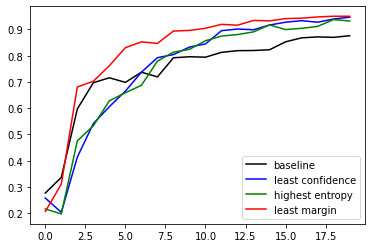

In [8]:
# visualize the performance difference
plt.plot(acc_baseline, 'k', label='baseline')
plt.plot(acc_vr, 'b', label='least confidence')
plt.plot(acc_entropy, 'g', label='highest entropy')
plt.plot(acc_bt, 'r', label='least margin')
plt.legend()